In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set global variables
PROJECT = r"Z:\Laboral\World Bank\Paper - Child mortality and Climate Shocks"
OUTPUTS = rf"{PROJECT}\Outputs"
DATA = rf"{PROJECT}\Data"
DATA_IN = rf"{DATA}\Data_in"
DATA_PROC = rf"{DATA}\Data_proc"
DATA_OUT = rf"{DATA}\Data_out"
ERA5_DATA = rf"Z:\WB Data\ERA5 Reanalysis\monthly"

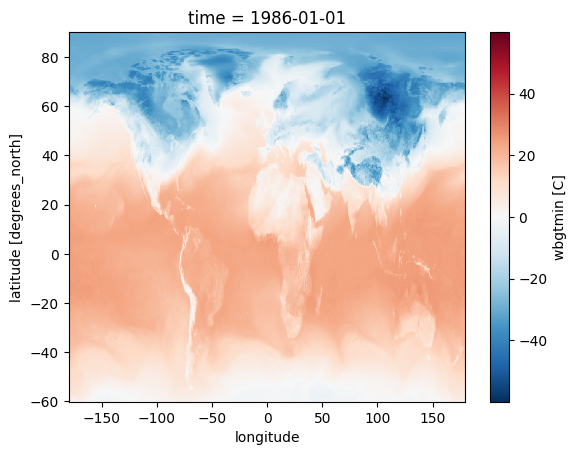

In [3]:
xr.open_dataset(r"Z:\WB Data\WBGT dialy\wbgt_daily_min_1979_1999\wbgtmin_1986_daily_ERA5.nc").isel(time=0).wbgtmin.plot()

## Variable definitions

- Drought: Monthly cumulative precipitation **2.5 standard deviations below** the monthly historical average, considering 30 years to estimate historical averages and SD
- Excessive Rain: Monthly cumulative precipitation **2.5 standard deviations above** the monthly historical average, considering 30 years to estimate historical averages and SD
- Heatwave: More than 6 days with temperature **over 40 degrees** and 2.5 standard deviations higher than monthly historical average, considering 30 years to estimate historical averages and SD. Furthermore, **warm spell** duration index is higher than 6 days.
- Coldwave: More than 6 days with temperature **below 0 degrees** and 2.5 standard deviations lower than monthly historical average, considering 30 years to estimate historical averages and SD. Furthermore, **cold spell** duration index is higher than 6 days.
  ​

In [2]:
files = os.listdir(ERA5_DATA)
datasets = []
for file in tqdm(files):
    ds = xr.open_dataset(os.path.join(ERA5_DATA, file))
    datasets += [ds]
precipitation = xr.concat(datasets, dim="time")
precipitation.to_netcdf(os.path.join(DATA_OUT, "ERA5_monthly_1970-2021.nc"))

  0%|          | 0/51 [00:00<?, ?it/s]C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
100%|██████████| 51/51 [00:03<00:00, 13.01it/s]
C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\xarray\core\concat.py:532: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [8]:
from metpy.calc import wet_bulb_temperature
from metpy.units import units

precipitation = xr.open_dataset(os.path.join(DATA_OUT, "ERA5_monthly_1970-2021.nc"), chunks={"time": 1, "latitude": 25, "longitude": 25})
precipitation = precipitation.isel(time=slice(0, 2), latitude=slice(0, 50), longitude=slice(0, 50))
wet_bulb_temperature = wet_bulb_temperature(
    precipitation.sp * units.Pa,
    precipitation.t2m * units.degK,
    precipitation.d2m * units.degK,).rename(f"wbgt")


C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\dask\array\core.py:1638: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\dask\array\core.py:1638: FutureWarning: The `numpy.place` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\dask\array\core.py:1638: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
C:\Users\ofici\AppData\Roaming\Pyth

In [9]:
wet_bulb_temperature

Magnitude,[[[243.86199125170205 243.86199125170205 243.86199125170205 ... 243.86199125170205 243.86199125170205 243.86199125170205] [243.6117604240331 243.61346635191708 243.61354786469275 ... 243.6733164533401 243.6750174336746 243.6750935447547] [243.414066107513 243.415690913106 243.4203874384892 ... 243.5105641546692 243.51535773111578 243.5169665316863] ... [261.4664578867266 261.5934140343312 261.7111616107569 ... 260.8523625961238 260.4876391240088 260.1202119168567] [262.4466925073576 262.6002257112976 262.75120290856796 ... 262.01282406639297 261.6198985974947 261.22462164896103] [263.34478903979766 263.5012255249018 263.65940417462633 ... 263.1301185312143 262.90368057463644 262.6782559675049]] [[244.03654052764557 244.03654052764557 244.03654052764557 ... 244.03654052764557 244.03654052764557 244.03654052764557] [244.04850575996778 244.04850575996778 244.04850575996778 ... 244.07936243833387 244.08088339113786 244.08088339113786] [244.06374953648452 244.06374953648452 244.0669865827496 ... 244.12658066510798 244.12667842778157 244.1298222552056] ... [260.51788465855924 260.644674354371 260.77842409252213 ... 260.4029260468002 259.9376261074379 259.4693954110137] [261.6045111339121 261.7190303157822 261.8306434608663 ... 260.0185040604452 259.37106641592396 258.72311882724057] [262.50288957591306 262.61462245142326 262.7084746666589 ... 260.4544373377656 259.9072613919507 259.35864366457963]]]
Units,kelvin


In [3]:
import dask

precipitation = xr.open_dataset(os.path.join(DATA_OUT, "ERA5_monthly_1970-2021.nc"))

# Longitude is in range 0-360, with 0 at Greenwich. We need to transform it to -180 to 180
def transform_longitude(longitude):
    if longitude > 180:
        return longitude - 360
    else:
        return longitude

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
precipitation['longitude'] = precipitation['longitude'].to_series().apply(transform_longitude).values
precipitation = precipitation.sortby('longitude').sortby("latitude")
precipitation = precipitation.rename({'longitude': 'lon', 'latitude': 'lat'})

C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


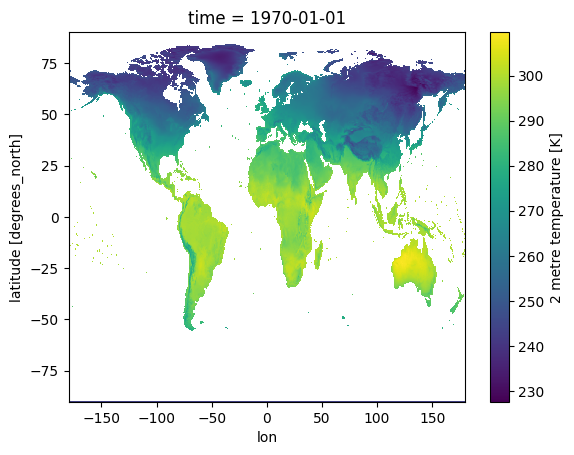

In [65]:
## Mask values on the sea, as we only need country data.
# Data from countries comes from non-nan values in the precipitation_cckp dataset
countries = xr.open_dataset(fr"{DATA_IN}\Climate Data\timeseries-pr-monthly-mean_cru_monthly_cru-ts4.06-timeseries_mean_1901-2021.nc")
mask = countries['timeseries-pr-monthly-mean'].isel(time=0).notnull()
# Interpolate mask to ERA5 resolution
mask = mask.astype(int).interp(lat=precipitation.lat, lon=precipitation.lon, method='nearest').astype(bool)

# Mask data
precipitation = precipitation.where(mask)

In [74]:
from climate_indices import indices, compute
#### Running this takes... A lot. Aprox. 90m for each SPI, so ~7.5h for all SPIs.

## Script based on: https://github.com/monocongo/climate_indices/issues/326
## Original paper: https://www.droughtmanagement.info/literature/AMS_Relationship_Drought_Frequency_Duration_Time_Scales_1993.pdf
## User guide to SPI: https://digitalcommons.unl.edu/cgi/viewcontent.cgi?article=1208&context=droughtfacpub
#   It is recommended to use SPI-9 or SPI-12 to compute droughts.
#   "SPI values below -1.5 for these timescales (SPI-9) are usually a good indication that dryness is having a significant impact on
#    agriculture and may be affecting other sectors as well."
## More here: https://www.researchgate.net/profile/Sorin-Cheval/publication/264467702_Spatiotemporal_variability_of_the_meteorological_drought_in_Romania_using_the_Standardized_Precipitation_Index_SPI/links/5842d18a08ae2d21756372f8/Spatiotemporal-variability-of-the-meteorological-drought-in-Romania-using-the-Standardized-Precipitation-Index-SPI.pdf
## Ignore negative values, they are normal: https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ

# Parameters
distribution = indices.Distribution.gamma
data_start_year = 1970
calibration_year_initial = 1970
calibration_year_final = 2020
periodicity = compute.Periodicity.monthly


da_precip_groupby = precipitation["tp"].stack(point=('lat', 'lon')).groupby('point')

# apply SPI to each `point`
spis = []
for i in [1, 3, 6, 9, 12]:
    print(f"Computing SPI-{i}")
    da_spi = xr.apply_ufunc(indices.spi,
                            da_precip_groupby,
                            i,
                            distribution,
                            data_start_year,
                            calibration_year_initial,
                            calibration_year_final,
                            periodicity,
    )
    da_spi = da_spi.unstack('point').rename(f"spi{i}")
    da_spi.to_netcdf(os.path.join(DATA_OUT, f"ERA5_monthly_1970-2021_SPI{i}.nc"))
    spis += [da_spi]

Computing SPI-3


C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:712: RuntimeWarning: divide by zero encountered in divide
  alphas = (1 + np.sqrt(1 + 4 * a / 3)) / (4 * a)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2168: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


In [ ]:
if len(spis) != 5:
    spis = [xr.open_dataset(os.path.join(DATA_OUT, f"ERA5_monthly_1970-2021_SPI{i}.nc")) for i in [1, 3, 6, 9, 12]]
    
#### Construct indicators
climate_data = xr.combine_by_coords(spis + [precipitation["t2m"]])

## Export data
climate_data.to_netcdf(rf"{DATA_OUT}/Climate_shocks_v3_previous_months.nc")

In [ ]:
import pandas as pd
pd.read_csv(r"Z:\Laboral\World Bank\Paper - Child mortality and Climate Shocks\Data\Data_proc\births_climate_20000.csv")